In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

enable_code_paths = False

if enable_code_paths:
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/dataset/clean_dataset.csv"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/dataset/14_002_NLP/model"
else :
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/model"

import sys
helpers_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
sys.path.append(helpers_path)

from colab_helper import proportion_balance_classes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we will be installing all the modules that are required

In [ ]:
!pip install torchinfo

We will be exploring the Bert model and see if we could find any good performance

In [ ]:
# main libraries
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchinfo import summary  # Model summary tool for PyTorch

# Transformers Library (for BERT and related utilities)
from transformers import BertTokenizer, BertModel, BertConfig

# Evaluation and Metrics
from sklearn import metrics

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# colorama
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
dataframe = pd.read_csv(URL_path)
dataframe["not_toxic"] = ((dataframe.iloc[:, 1:] == 0).all(axis=1)).astype(int)
dataframe.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


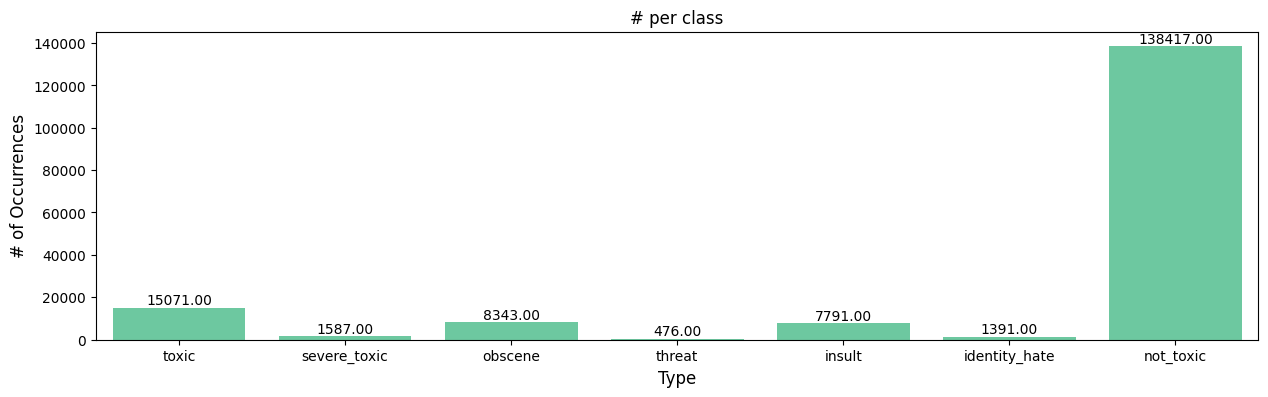

In [ ]:
target_y =dataframe.iloc[:,1:].sum()
proportion_balance_classes(target_y.index, target_y.values)

We will now apply undersampling to the dataset to see if it improves performance. For this step, we’ll reduce all comment classes to a maximum of 500 instances and observe how it affects the overall results.

In [ ]:
sample_1 = dataframe[dataframe["threat"] == 1]
sample_2 = dataframe[dataframe["identity_hate"] == 1 & (~dataframe.index.isin(sample_1.index))]
sample_3 = dataframe[(dataframe["severe_toxic"] == 1) &
                     (~dataframe.index.isin(sample_1.index)) &
                     (~dataframe.index.isin(sample_2.index))]
sample_4 = dataframe[(dataframe["insult"] == 1) &
                          (~dataframe.index.isin(sample_1.index)) &
                          (~dataframe.index.isin(sample_2.index)) &
                          (~dataframe.index.isin(sample_3.index))]
sample_5 = dataframe[(dataframe["obscene"] == 1) &
                           (~dataframe.index.isin(sample_1.index)) &
                           (~dataframe.index.isin(sample_2.index)) &
                            (~dataframe.index.isin(sample_4.index)) &
                           (~dataframe.index.isin(sample_3.index))]

sample_6 = dataframe[(dataframe["toxic"] == 1) &
                         (~dataframe.index.isin(sample_1.index)) &
                         (~dataframe.index.isin(sample_2.index)) &
                        (~dataframe.index.isin(sample_4.index)) &
                        (~dataframe.index.isin(sample_5.index)) &
                         (~dataframe.index.isin(sample_3.index))]

sample_non_toxic = dataframe[(dataframe["not_toxic"] == 1) &
                         (~dataframe.index.isin(sample_1.index)) &
                         (~dataframe.index.isin(sample_2.index)) &
                        (~dataframe.index.isin(sample_4.index)) &
                        (~dataframe.index.isin(sample_5.index)) &
                        (~dataframe.index.isin(sample_6.index)) &
                         (~dataframe.index.isin(sample_3.index))]

print("Sample 1 (Threat):", sample_1.shape[0])
print("Sample 2 (Identity Hate):", sample_2.shape[0])
print("Sample 3 (Severe Toxic):", sample_3.shape[0])
print("Sample 4 (Insult):", sample_4.shape[0])
print("Sample 5 (Obscene):", sample_5.shape[0])
print("Sample 6 (Toxic):", sample_6.shape[0])
print("Sample Non Toxic:", sample_non_toxic.shape[0])

Sample 1 (Threat): 476
Sample 2 (Identity Hate): 1673
Sample 3 (Severe Toxic): 1197
Sample 4 (Insult): 5426
Sample 5 (Obscene): 2039
Sample 6 (Toxic): 5552
Sample Non Toxic: 138417


We will now extract the training set, limiting the maximum values to around 1,000. This adjustment aims to enhance the model's performance.

Combined Samples Count: 6476
tensor([0.3296, 0.0846, 0.2339, 0.0461, 0.1864, 0.0550, 0.0643])


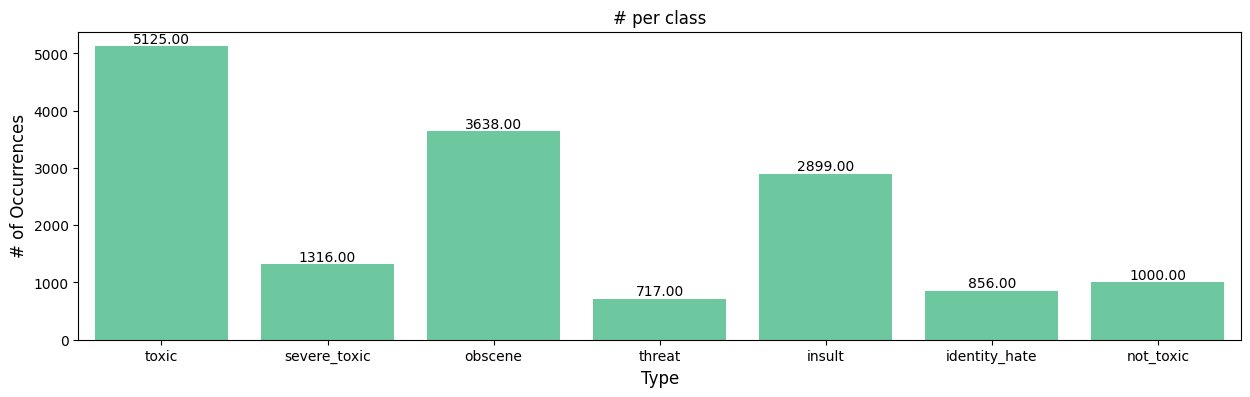

In [ ]:
values_sampling = int(1000)
sample_1_sampled = sample_1.sample(n=sample_1.shape[0], random_state=42, replace= False)
sample_2_sampled = sample_2.sample(n=values_sampling, random_state=42, replace=False)
sample_3_sampled = sample_3.sample(n=values_sampling, random_state=42, replace=False)
sample_4_sampled = sample_4.sample(n=values_sampling, random_state=42, replace=False)
sample_5_sampled = sample_5.sample(n=values_sampling, random_state=42, replace=False)
sample_6_sampled = sample_6.sample(n=values_sampling, random_state=42, replace=False)
sample_non_toxic_sampled = sample_non_toxic.sample(n=values_sampling, random_state=42)

combined_samples = pd.concat([sample_1_sampled, sample_2_sampled, sample_3_sampled,
                               sample_4_sampled, sample_5_sampled, sample_6_sampled,
                               sample_non_toxic_sampled], ignore_index=True)

# combined_samples = combined_samples.drop(columns=["list"])

print("Combined Samples Count:", combined_samples.shape[0])
target_y =combined_samples.iloc[:,1:].sum()

# extracting the weights
weights_list = target_y.tolist()
weights = torch.tensor(weights_list, dtype=torch.float32)
normalized_weights = weights / weights.sum()
print(normalized_weights)

proportion_balance_classes(target_y.index, target_y.values)

We still had not proportional dataset, this because we had some features that can be categorize in several target, so we will try to continue using this dataset and split the data.

In [ ]:
combined_samples.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,"if you do not stop, the wikapidea nijas will c...",1,0,0,1,0,0,0
1,Fuck you Sarcasticidealist i will kill you wit...,1,1,1,1,1,0,0
2,My personal opinion Is that you're a fucking w...,1,0,1,1,1,0,0


Now that we had a smaller dataset with all the data around the same balance, we will try to

In [ ]:
combined_samples['list'] = combined_samples[combined_samples.columns[1:]].values.tolist()
dataframe_clean = combined_samples[['comment_text', 'list']].copy()
dataframe_clean.head()

,comment_text,list
0,"if you do not stop, the wikapidea nijas will c...","[1, 0, 0, 1, 0, 0, 0]"
1,Fuck you Sarcasticidealist i will kill you wit...,"[1, 1, 1, 1, 1, 0, 0]"
2,My personal opinion Is that you're a fucking w...,"[1, 0, 1, 1, 1, 0, 0]"
3,Graeme Bartlet MUST die,"[1, 0, 0, 1, 0, 0, 0]"
4,""":spade_suit:ΜōōŠε:spade_suit: u suck loser. ...","[1, 0, 1, 1, 1, 0, 0]"


 # Parameters model

In this case, we selected 256 as the maximum token length because values above this threshold represent only about 5% of the data, making them statistically insignificant. Removing these outliers helps streamline training and improve efficiency. For this iteration, we will use training and validation batches of 8, with an initial learning rate set at 1e-05. The first model we will be testing is BERT.

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# name of the model to save
model_name_to_save = "002_model_bert"

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class CustomDataset(Dataset):
    """Tokenize the dataset for using it in the model"""
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        values_return = {
                        'ids': torch.tensor(ids, dtype=torch.int64),
                        'mask': torch.tensor(mask, dtype=torch.int64),
                        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
                        'targets': torch.tensor(self.targets[index], dtype=torch.float)
                         }

        return values_return

# split and dataloader

In [ ]:
# split
train_size = 0.8
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
test_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# transforming the dataset
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

FULL Dataset: (6476, 2)
TRAIN Dataset: (5181, 2)
TEST Dataset: (1295, 2)


# Fine tune the model

In [ ]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        # because we are trying to predict 7 classes
        self.l3 = torch.nn.Linear(768, 7)

        # freeze the layers
        for param in self.l1.parameters():
            param.requires_grad = False
        for param in self.l1.encoder.layer[-1].parameters():
            param.requires_grad = True

    def forward(self, ids, mask, token_type_ids):

        assert isinstance(ids, torch.Tensor), f"Expected tensor, got {type(ids)} for ids"
        assert isinstance(mask, torch.Tensor), f"Expected tensor, got {type(mask)} for mask"
        assert isinstance(token_type_ids, torch.Tensor), f"Expected tensor, got {type(token_type_ids)} for token_type_ids"

        # _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)


        # print(f"Type of outputs: {type(output_1)}")
        output_1 = output_1[1]

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model_bert = BertClass()
model_bert.to(device)

summary(model_bert)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Param #
BertClass                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,383
Total 

# train the model

In [ ]:
# loss function
loss_fun_object = torch.nn.BCEWithLogitsLoss(pos_weight=normalized_weights)
def loss_fn(outputs, targets):
    return loss_fun_object(outputs, targets)

# optimizer
param_groups = [
    {'params': model_bert.l1.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model_bert.l3.parameters(), 'lr': LEARNING_RATE},
]

# Create the optimizer using AdamW with parameter groups
optimizer = torch.optim.AdamW(param_groups, weight_decay=0.001)

# store loss s can accuracy and calculated
def calculate_accuracy(outputs, targets):
    preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = preds.round()  # Round to get binary predictions
    return (preds == targets).float().mean()  # Calculate accuracy

loss_history = []
accuracy_history = []

# training and epochs
def train(epoch, model, dataset_loader, device, enable_code = False):
    """ Train the model"""
    model.train()

    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0

    # run each sample on the model
    for _,data in tqdm(enumerate(dataset_loader, 0)):
        ids =  data['ids'].to(device, dtype = torch.int64)
        mask = data['mask'].to(device, dtype = torch.int8 )
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.int64)
        targets = data['targets'].to(device, dtype=torch.float64)

        outputs = model(ids, mask, token_type_ids)

        # calculate the gradient
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, targets).item() * ids.size(0)
        total_samples += ids.size(0)


        if _ % 5000 == 0:
            accuracy = calculate_accuracy(outputs, targets).item()  # Calculate accuracy for current batch
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}')

        # plot the accuracy and the loss
        epoch_loss = running_loss / len(dataset_loader)
        epoch_accuracy = running_accuracy / total_samples
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        return model, loss_history, accuracy_history


After seeing the model traing for 200 epochs we could see that the accuracy of its for 80% so we will need to validate it to see how it handle its.

# Validation set

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
loss_values = []
accuracy_values = []

def validation(epoch, model, dataloader, device, loss_fun):
    model.eval()  # Set model to evaluation mode
    fin_targets = []
    fin_outputs = []
    total_loss = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)  # Calculate the loss for the current batch
            total_loss += loss.item()  # Accumulate the loss

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    # Calculate average loss over the entire validation set
    avg_loss = total_loss / len(dataloader)

    # Convert outputs and targets to numpy arrays for accuracy calculation
    fin_outputs = (np.array(fin_outputs) > 0.5).astype(int)  # Thresholding the outputs
    fin_targets = np.array(fin_targets)

    # Calculate accuracy
    accuracy = accuracy_score(fin_targets, fin_outputs)
    print(f"Epoch: {epoch}, Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    loss_values.append(avg_loss)
    accuracy_values.append(accuracy)

    return fin_outputs, fin_targets, loss_values, accuracy_values


In [ ]:
for epoch in range(EPOCHS):

    print("==Training===")
    start_time = time.time()
    print(f'The training_loader: {training_loader}')
    model_bert, loss_history_train, accuracy_history_train = train(epoch, model_bert, training_loader, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
    print("Loss History:", loss_history_train)
    print("Accuracy History:", accuracy_history_train)

    print("==Testing===")
    print(f'The testing_loader: {testing_loader}')
    outputs, targets, loss_history_valid ,accuracy_history_valid  = validation(epoch, model_bert, testing_loader, device, loss_fun_object)
    print("Loss History:", loss_history_valid)
    print("Accuracy History:", accuracy_history_valid)

    end_time = time.time()
    epoch_duration = start_time - end_time
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')

==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 0, Loss: 0.4599760236285095, Accuracy: 0.4464285671710968
Epoch 1/20 completed in 0.36 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968]
==Testing===


162it [00:37,  4.33it/s]


Epoch: 0, Validation Loss: 0.5182, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602]
Accuracy History: [0.0, 0.0, 0.0]
Epoch 1/20 completed in -37.78 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 1, Loss: 0.5061030296741852, Accuracy: 0.4642857015132904
Epoch 2/20 completed in 0.33 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904]
==Testing===


162it [00:38,  4.18it/s]


Epoch: 1, Validation Loss: 0.5170, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563]
Accuracy History: [0.0, 0.0, 0.0, 0.0]
Epoch 2/20 completed in -39.09 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 2, Loss: 0.47227927267418374, Accuracy: 0.5714285969734192
Epoch 3/20 completed in 0.37 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192]
==Testing===


162it [00:40,  3.98it/s]


Epoch: 2, Validation Loss: 0.5159, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 3/20 completed in -41.06 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 3, Loss: 0.5312885524305914, Accuracy: 0.4285714328289032
Epoch 4/20 completed in 0.36 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032]
==Testing===


162it [00:37,  4.30it/s]


Epoch: 3, Validation Loss: 0.5148, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 4/20 completed in -38.05 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 4, Loss: 0.529873830598912, Accuracy: 0.5178571343421936
Epoch 5/20 completed in 0.38 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936]
==Testing===


162it [00:40,  3.96it/s]


Epoch: 4, Validation Loss: 0.5135, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 5/20 completed in -41.32 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 5, Loss: 0.5129989434166679, Accuracy: 0.5535714030265808
Epoch 6/20 completed in 0.34 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808]
==Testing===


162it [00:34,  4.65it/s]


Epoch: 5, Validation Loss: 0.5124, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 6/20 completed in -35.23 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 6, Loss: 0.5727957441205425, Accuracy: 0.4285714328289032
Epoch 7/20 completed in 0.30 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032]
==Testing===


162it [00:35,  4.60it/s]


Epoch: 6, Validation Loss: 0.5112, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 7/20 completed in -35.56 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 7, Loss: 0.5447450481754329, Accuracy: 0.4642857015132904
Epoch 8/20 completed in 0.48 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904]
==Testing===


162it [00:40,  3.98it/s]


Epoch: 7, Validation Loss: 0.5100, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 8/20 completed in -41.24 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 8, Loss: 0.531166887476242, Accuracy: 0.5178571343421936
Epoch 9/20 completed in 0.35 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936]
==Testing===


162it [00:39,  4.14it/s]


Epoch: 8, Validation Loss: 0.5088, Accuracy: 0.0000
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 9/20 completed in -39.47 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 9, Loss: 0.517377315887383, Accuracy: 0.5357142686843872
Epoch 10/20 completed in 0.51 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872]
==Testing===


162it [00:37,  4.34it/s]


Epoch: 9, Validation Loss: 0.5077, Accuracy: 0.0015
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444]
Epoch 10/20 completed in -37.85 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 10, Loss: 0.5058310014594879, Accuracy: 0.4821428656578064
Epoch 11/20 completed in 0.34 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656578064]
==Testing===


162it [00:37,  4.30it/s]


Epoch: 10, Validation Loss: 0.5064, Accuracy: 0.0015
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444]
Epoch 11/20 completed in -37.98 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 11, Loss: 0.4466901528316417, Accuracy: 0.5178571343421936
Epoch 12/20 completed in 0.38 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656578064, 0.5178571343421936]
==Testing===


162it [00:36,  4.41it/s]


Epoch: 11, Validation Loss: 0.5053, Accuracy: 0.0015
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444]
Epoch 12/20 completed in -37.14 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 12, Loss: 0.49308308450106, Accuracy: 0.4285714328289032
Epoch 13/20 completed in 0.38 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656578064, 0.5178571343421936, 0.4285714328289032]
==Testing===


162it [00:35,  4.59it/s]


Epoch: 12, Validation Loss: 0.5041, Accuracy: 0.0023
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165]
Epoch 13/20 completed in -35.70 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 13, Loss: 0.5121632025776697, Accuracy: 0.5714285969734192
Epoch 14/20 completed in 0.46 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656578064, 0.5178571343421936, 0.4285714328289032, 0.5714285969734192]
==

162it [00:38,  4.18it/s]


Epoch: 13, Validation Loss: 0.5029, Accuracy: 0.0023
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165]
Epoch 14/20 completed in -39.26 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 14, Loss: 0.493338112719357, Accuracy: 0.5178571343421936
Epoch 15/20 completed in 0.40 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606, 0.0007613242480236991]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656578064, 0.5178571343421936, 0.4285714328289032, 

162it [00:35,  4.50it/s]


Epoch: 14, Validation Loss: 0.5018, Accuracy: 0.0023
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488, 0.501812360536905]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165]
Epoch 15/20 completed in -36.40 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 15, Loss: 0.4332166691643319, Accuracy: 0.5178571343421936
Epoch 16/20 completed in 0.51 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606, 0.0007613242480236991, 0.0006685442425375492]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656578064, 0.51785713434219

162it [00:35,  4.57it/s]


Epoch: 15, Validation Loss: 0.5007, Accuracy: 0.0023
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488, 0.501812360536905, 0.5007010010289558]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165]
Epoch 16/20 completed in -36.00 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 16, Loss: 0.47159811618205694, Accuracy: 0.5714285969734192
Epoch 17/20 completed in 0.29 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606, 0.0007613242480236991, 0.0006685442425375492, 0.0007277748706513225]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.5357142686843872, 0.4821428656

162it [00:38,  4.25it/s]


Epoch: 16, Validation Loss: 0.4996, Accuracy: 0.0023
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488, 0.501812360536905, 0.5007010010289558, 0.49961230085219865]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165]
Epoch 17/20 completed in -38.43 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 17, Loss: 0.5201155042408833, Accuracy: 0.4642857015132904
Epoch 18/20 completed in 0.42 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606, 0.0007613242480236991, 0.0006685442425375492, 0.0007277748706513225, 0.0008026473830877828]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.53571426

162it [00:37,  4.37it/s]


Epoch: 17, Validation Loss: 0.4985, Accuracy: 0.0031
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488, 0.501812360536905, 0.5007010010289558, 0.49961230085219865, 0.4985243656017162]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.003088803088803089]
Epoch 18/20 completed in -37.55 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 18, Loss: 0.5207099663093686, Accuracy: 0.5
Epoch 19/20 completed in 0.39 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606, 0.0007613242480236991, 0.0006685442425375492, 0.0007277748706513225, 0.0008026473830877828, 0.0008035647628230997]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.4642857015132904, 0.5178571343421936, 0.

162it [00:35,  4.52it/s]


Epoch: 18, Validation Loss: 0.4975, Accuracy: 0.0031
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488, 0.501812360536905, 0.5007010010289558, 0.49961230085219865, 0.4985243656017162, 0.4974686529165433]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.003088803088803089, 0.003088803088803089]
Epoch 19/20 completed in -36.23 seconds.
==Training===


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


Epoch: 19, Loss: 0.5250837102731956, Accuracy: 0.6071428656578064
Epoch 20/20 completed in 0.41 seconds.
Loss History: [0.0007799953137889071, 0.0008500815069219147, 0.0007921441988810088, 0.0008154780353662579, 0.0007524292346712603, 0.0007214013957176226, 0.0007098395426365887, 0.0007810231939416438, 0.000728826038077444, 0.0008198897414052336, 0.0008177065287020247, 0.0007916650361368331, 0.0008839440495687383, 0.0008406559385423347, 0.0008197019868460524, 0.0007984217837768257, 0.0007806033973140245, 0.0006893366556043854, 0.0007609306859584259, 0.0007903753126198606, 0.0007613242480236991, 0.0006685442425375492, 0.0007277748706513225, 0.0008026473830877828, 0.0008035647628230997, 0.0008103143677055486]
Accuracy History: [0.6071428656578064, 0.4107142984867096, 0.4107142984867096, 0.5357142686843872, 0.3928571343421936, 0.4464285671710968, 0.4464285671710968, 0.4642857015132904, 0.5714285969734192, 0.4285714328289032, 0.5178571343421936, 0.5535714030265808, 0.4285714328289032, 0.46

162it [00:37,  4.29it/s]

Epoch: 19, Validation Loss: 0.4964, Accuracy: 0.0031
Loss History: [0.5205812781681249, 0.5194220007569702, 0.5182449696240602, 0.5170358502202563, 0.5159159148180926, 0.5147530659113402, 0.5135381111392269, 0.512389126567193, 0.5111790590080214, 0.5100242490017856, 0.508796172009574, 0.5076549560935409, 0.5063869914522877, 0.5052914264393441, 0.5041187486530821, 0.5029233305910488, 0.501812360536905, 0.5007010010289558, 0.49961230085219865, 0.4985243656017162, 0.4974686529165433, 0.4963846410866137]
Accuracy History: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015444015444015444, 0.0015444015444015444, 0.0015444015444015444, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.0023166023166023165, 0.003088803088803089, 0.003088803088803089, 0.003088803088803089]
Epoch 20/20 completed in -38.14 seconds.


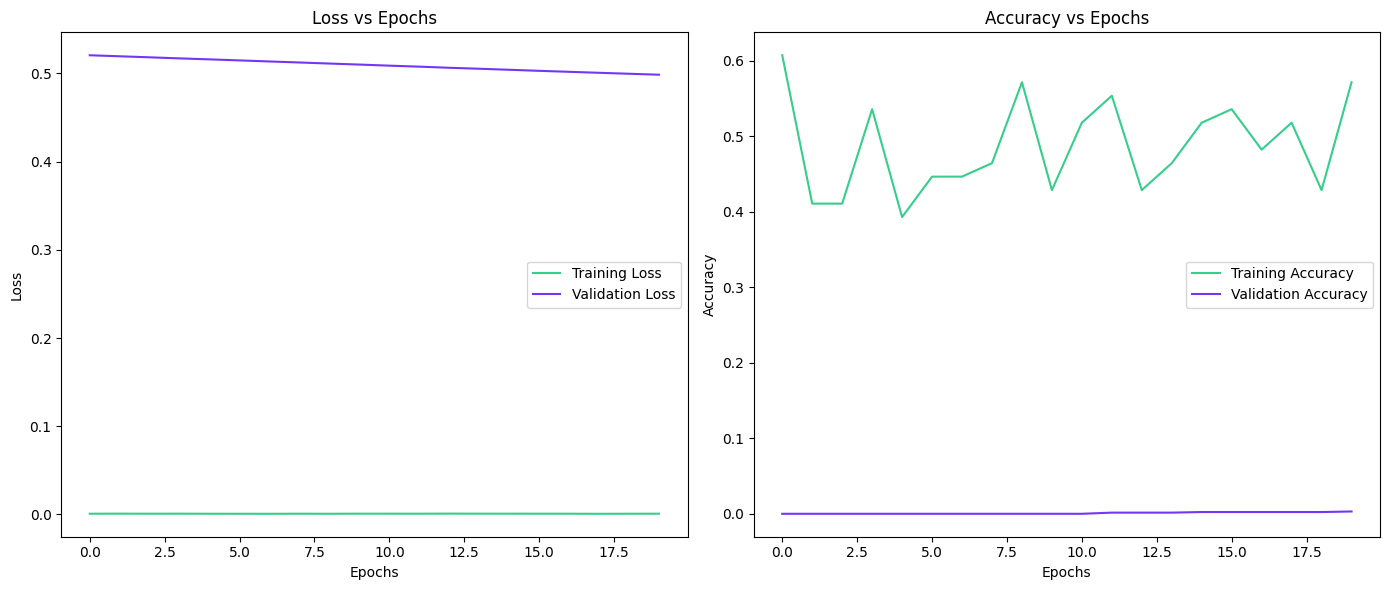

In [ ]:
# Plotting the loss and accuracy history
epochs = range(20)
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history_train[:20], label="Training Loss")
plt.plot(epochs, loss_history_valid[:20], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_history_train[:20], label="Training Accuracy")
plt.plot(epochs, accuracy_history_valid[:20], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
report_df

,precision,recall,f1-score,support
toxic,0.794436,0.503428,0.616307,1021.0
severe_toxic,0.113208,0.048193,0.067606,249.0
obscene,0.569106,0.096819,0.165485,723.0
threat,0.090762,0.973913,0.166049,115.0
insult,0.461429,0.547458,0.500775,590.0
identity_hate,0.000000,0.000000,0.000000,161.0
not_toxic,0.162869,0.910377,0.276306,212.0
micro avg,0.306306,0.398567,0.346399,3071.0
macro avg,0.313116,0.440027,0.256075,3071.0
weighted avg,0.510576,0.398567,0.370843,3071.0


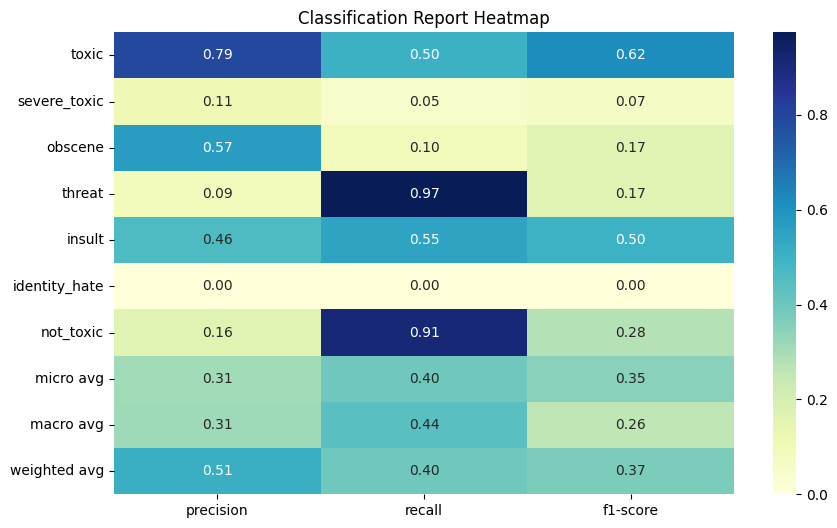

In [ ]:
report = metrics.classification_report(targets, outputs, output_dict=True)
report_df = pd.DataFrame(report).transpose()
class_names = combined_samples.iloc[:,1:-1].columns.tolist()

for i in range(len(class_names)):
    report_df.rename(index={str(i): class_names[i]}, inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


The model performs well for certain classes like toxic and insult, with relatively higher precision and recall, but struggles with others, notably identity_hate and severe_toxic, where it achieves low or even zero scores. This suggests the model has difficulty identifying nuances in some categories, potentially due to class imbalance or insufficient feature learning.

# Export the model
We will be exporting the model

In [ ]:
torch.save(model_bert, f'{URL_path_save}/{model_name_to_save}.pth')

# Load the model

In [ ]:
model_bert_loaded = torch.load(f'{URL_path_save}/{model_name_to_save}.pth')
model_bert_loaded

<ipython-input-166-9cc469be5fb3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_bert_loaded = torch.load(f'{URL_path_save}/{model_name_to_save}.pth')


BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# Summary

The model's overall performance is not yet optimal, so we should explore other techniques, such as applying class weights or using oversampling, to see if these methods improve its effectiveness.